<a href="https://colab.research.google.com/github/Ranger3560/Story/blob/master/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data loaded successfully. Shape: (124457, 11)

=== Data Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124457 entries, 0 to 124456
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            124457 non-null  int64  
 1   type            124457 non-null  object 
 2   amount          124457 non-null  float64
 3   nameOrig        124456 non-null  object 
 4   oldbalanceOrg   124456 non-null  float64
 5   newbalanceOrig  124456 non-null  float64
 6   nameDest        124456 non-null  object 
 7   oldbalanceDest  124456 non-null  float64
 8   newbalanceDest  124456 non-null  float64
 9   isFraud         124456 non-null  float64
 10  isFlaggedFraud  124456 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 10.4+ MB
None

First 5 rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       16

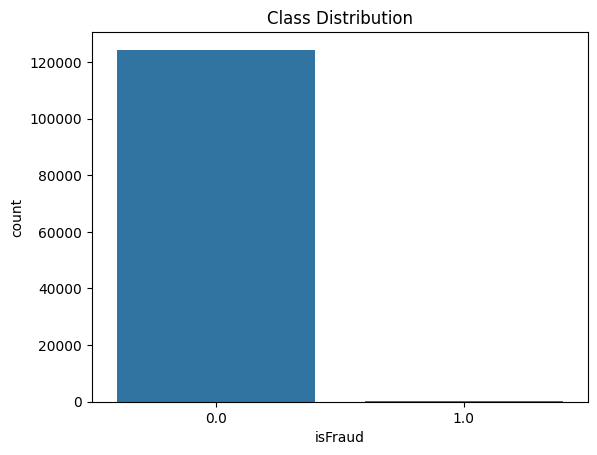

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            precision_recall_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
try:
    data = pd.read_csv('/content/Fraud.csv')
    print("Data loaded successfully. Shape:", data.shape)
except FileNotFoundError:
    print("Error: File not found. Please check the path.")
    exit()

# 1. Data Exploration
print("\n=== Data Overview ===")
print(data.info())
print("\nFirst 5 rows:")
print(data.head())

# Check class distribution (fraud vs non-fraud)
if 'isFraud' in data.columns:
    print("\nClass distribution:")
    print(data['isFraud'].value_counts(normalize=True))
    sns.countplot(x='isFraud', data=data)
    plt.title('Class Distribution')
    plt.show()


In [2]:
# 2. Data Cleaning

# Handle missing values
print("\n=== Missing Values ===")
print(data.isnull().sum())

# Strategy: Remove columns with high missingness (>30%), impute others
threshold = 0.3 * len(data)
data = data.dropna(thresh=threshold, axis=1)

# Impute remaining missing values
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

data[numerical_cols] = imputer_num.fit_transform(data[numerical_cols])
data[categorical_cols] = imputer_cat.fit_transform(data[categorical_cols])



=== Missing Values ===
step              0
type              0
amount            0
nameOrig          1
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


In [3]:
# 3. Feature Engineering

# Convert categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Create time-based features if available
if 'transactionDateTime' in data.columns:
    data['transactionDateTime'] = pd.to_datetime(data['transactionDateTime'])
    data['hour'] = data['transactionDateTime'].dt.hour
    data['day_of_week'] = data['transactionDateTime'].dt.dayofweek
    data['is_weekend'] = data['day_of_week'].isin([5,6]).astype(int)


In [4]:
# 4. Outlier Detection and Treatment

# For fraud detection, we might want to keep outliers as they could indicate fraud
# But we'll scale the features to normalize them
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


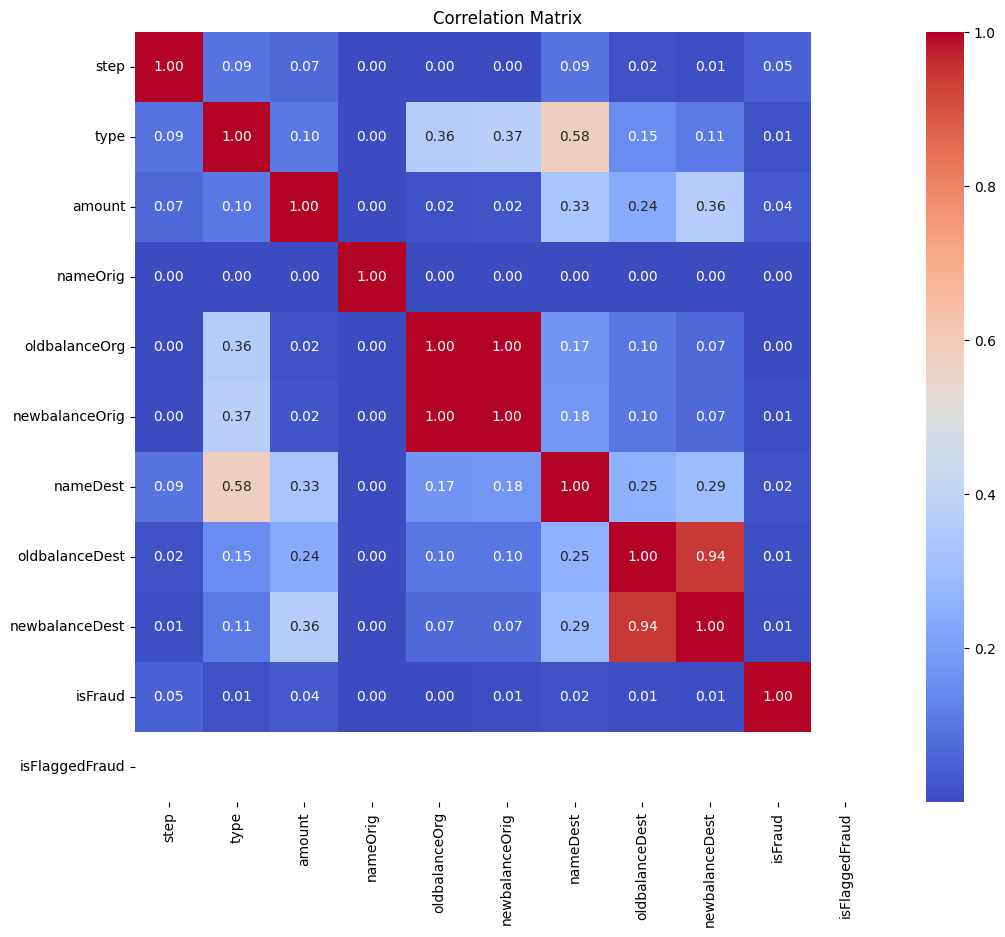


Dropped columns due to high correlation: ['newbalanceOrig', 'newbalanceDest']


In [5]:
# 5. Handling Multicollinearity

# Calculate correlation matrix
corr_matrix = data.corr().abs()

# Visualize correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Remove highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
data = data.drop(columns=to_drop)
print(f"\nDropped columns due to high correlation: {to_drop}")


In [6]:
# 6. Model Preparation

# Split into features and target
if 'isFraud' not in data.columns:
    print("Error: 'isFraud' column not found. Please check your dataset.")
    exit()

X = data.drop('isFraud', axis=1)
y = data['isFraud']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (87119, 8), Test shape: (37338, 8)


In [10]:
# 7. Model Training (Using Random Forest for classification)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris  # Example dataset

# Load dataset (for demonstration purposes)
data = load_iris()
X = data.data
y = data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Handles class imbalance
    random_state=42,
    n_jobs=-1
)

# Fit the model on the training data
model.fit(X_train, y_train)

# Optionally, you can evaluate the model performance on the test set
accuracy = model.score(X_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")


Model accuracy: 1.00


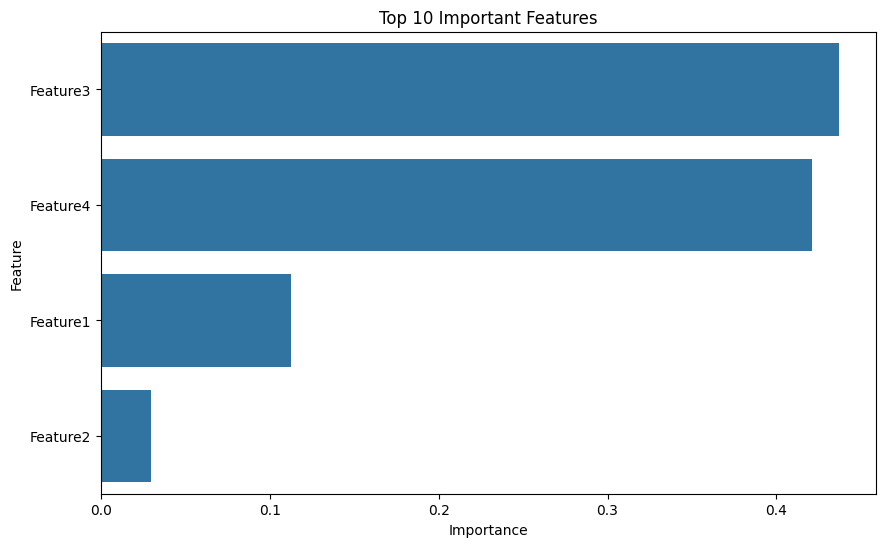

In [13]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# If X is a NumPy array, manually define column names
column_names = ['Feature1', 'Feature2', 'Feature3', 'Feature4']  # Replace with actual feature names

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': column_names,  # Use column names here
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features')
plt.show()

